# Introduction to Machine Learning for Aerosol Scientists
## Part 1: XGBoost for UVLIF Aerosol Classification

### Learning Objectives
By the end of this notebook, you will understand:
1. Train/test/validation splits and why they matter
2. Model evaluation using ROC curves and other metrics
3. Hyperparameter tuning to optimize model performance
4. How to apply gradient boosting (XGBoost) to classify aerosol types

### Background
UVLIF mass spectrometry generates fluorescence spectra that can distinguish between different aerosol types (biological, mineral dust, organic carbon, etc.). We'll use machine learning to automate this classification.

In [ ]:
# Install required packages
!pip install xgboost scikit-learn matplotlib seaborn pandas numpy -q

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix, 
                             roc_curve, auc, roc_auc_score)
from sklearn.preprocessing import label_binarize
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## Step 1: Generate Synthetic UVLIF Data

We'll create synthetic aerosol mass spectra for 4 aerosol types:
- **Biological**: Strong fluorescence at specific wavelengths (characteristic of proteins/NAD(P)H)
- **Mineral Dust**: Weak, broad fluorescence
- **Organic Carbon**: Moderate fluorescence with different spectral features
- **Polycyclic Aromatic Hydrocarbons (PAH)**: Strong fluorescence at longer wavelengths

In [ ]:
def generate_uvlif_spectrum(aerosol_type, n_wavelengths=64, noise_level=0.1):
    """
    Generate synthetic UVLIF spectrum for different aerosol types.
    
    Parameters:
    -----------
    aerosol_type : str
        Type of aerosol ('biological', 'mineral_dust', 'organic_carbon', 'pah')
    n_wavelengths : int
        Number of spectral channels (wavelength bins)
    noise_level : float
        Amount of random noise to add
    """
    wavelengths = np.linspace(0, 1, n_wavelengths)
    
    if aerosol_type == 'biological':
        # Two peaks: tryptophan-like (~280nm) and NAD(P)H-like (~340-460nm)
        spectrum = (3.0 * np.exp(-((wavelengths - 0.3)**2) / 0.01) + 
                   4.0 * np.exp(-((wavelengths - 0.5)**2) / 0.02))
        
    elif aerosol_type == 'mineral_dust':
        # Weak, broad, nearly flat response
        spectrum = 0.5 + 0.3 * np.exp(-((wavelengths - 0.5)**2) / 0.5)
        
    elif aerosol_type == 'organic_carbon':
        # Single broader peak in mid-range
        spectrum = 2.5 * np.exp(-((wavelengths - 0.4)**2) / 0.03)
        
    elif aerosol_type == 'pah':
        # Strong peak at longer wavelengths
        spectrum = 5.0 * np.exp(-((wavelengths - 0.7)**2) / 0.02)
    
    # Add realistic noise
    noise = noise_level * np.random.randn(n_wavelengths)
    spectrum = spectrum + noise
    
    # Ensure non-negative (like real fluorescence data)
    spectrum = np.maximum(spectrum, 0)
    
    return spectrum

# Generate dataset
np.random.seed(42)
n_samples_per_class = 250
aerosol_types = ['biological', 'mineral_dust', 'organic_carbon', 'pah']

data = []
labels = []

for aerosol_type in aerosol_types:
    for _ in range(n_samples_per_class):
        spectrum = generate_uvlif_spectrum(aerosol_type)
        data.append(spectrum)
        labels.append(aerosol_type)

# Convert to arrays
X = np.array(data)
y = np.array(labels)

print(f"Dataset shape: {X.shape}")
print(f"Classes: {aerosol_types}")
print(f"Samples per class: {n_samples_per_class}")

In [ ]:
# Visualize example spectra for each aerosol type
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for idx, aerosol_type in enumerate(aerosol_types):
    # Get indices for this class
    class_indices = np.where(y == aerosol_type)[0]
    
    # Plot several examples
    for i in range(5):
        axes[idx].plot(X[class_indices[i]], alpha=0.6, linewidth=1.5)
    
    axes[idx].set_title(f'{aerosol_type.replace("_", " ").title()}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Wavelength Channel', fontsize=10)
    axes[idx].set_ylabel('Fluorescence Intensity', fontsize=10)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('example_spectra.png', dpi=150, bbox_inches='tight')
plt.show()

print("Note the characteristic spectral signatures:")
print("- Biological: Two distinct peaks (proteins and NAD(P)H)")
print("- Mineral Dust: Weak, broad response")
print("- Organic Carbon: Single moderate peak")
print("- PAH: Strong peak at longer wavelengths")

## Step 2: Train/Test/Validation Split

### Why do we need multiple data splits?

1. **Training Set (60%)**: Used to train the model (learn patterns)
2. **Validation Set (20%)**: Used to tune hyperparameters and make decisions during model development
3. **Test Set (20%)**: Held out completely until the end - gives unbiased estimate of real-world performance

**Critical concept**: The test set must NEVER be used during model development. It's your "honest estimate" of how the model will perform on new, unseen aerosol samples.

In [ ]:
# First split: separate out test set (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Second split: divide remaining data into train (75% of 80% = 60%) and validation (25% of 80% = 20%)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print("Data splits:")
print(f"Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")
print("\n✓ Test set is locked away - we won't touch it until final evaluation!")

In [ ]:
# Feature scaling - important for many ML algorithms
# Fit scaler on training data only!
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

print("✓ Data scaled and labels encoded")

## Step 3: Train a Baseline XGBoost Model

**What is XGBoost?**
- Gradient Boosting algorithm: builds an ensemble of decision trees sequentially
- Each new tree corrects errors made by previous trees
- Very effective for tabular/structured data (like spectra)
- Popular in competitions and real-world applications

In [ ]:
# Train baseline model with default parameters
baseline_model = xgb.XGBClassifier(
    random_state=42,
    eval_metric='mlogloss'  # multiclass log loss
)

baseline_model.fit(X_train_scaled, y_train_encoded)

# Evaluate on validation set
val_predictions = baseline_model.predict(X_val_scaled)
val_accuracy = (val_predictions == y_val_encoded).mean()

print(f"Baseline Model Validation Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.2f}%)")
print("\nClassification Report (Validation Set):")
print(classification_report(y_val_encoded, val_predictions, 
                          target_names=label_encoder.classes_))

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_val_encoded, val_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - Baseline Model', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix_baseline.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nHow to read this: Diagonal = correct predictions, Off-diagonal = errors")

## Step 4: ROC Curves and AUC

**Receiver Operating Characteristic (ROC) curves** show the trade-off between:
- **True Positive Rate (Sensitivity)**: Correctly identifying aerosol type
- **False Positive Rate**: Incorrectly classifying other types as this type

**Area Under Curve (AUC)**:
- AUC = 1.0: Perfect classifier
- AUC = 0.5: Random guessing
- AUC > 0.9: Excellent performance

For multi-class problems, we compute one ROC curve per class (one-vs-rest approach).

In [ ]:
# Get probability predictions
y_val_proba = baseline_model.predict_proba(X_val_scaled)

# Binarize labels for ROC curve (one-vs-rest)
y_val_bin = label_binarize(y_val_encoded, classes=range(len(aerosol_types)))

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(aerosol_types)):
    fpr[i], tpr[i], _ = roc_curve(y_val_bin[:, i], y_val_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = ['blue', 'red', 'green', 'orange']

for i, (color, aerosol_type) in enumerate(zip(colors, aerosol_types)):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{aerosol_type.replace("_", " ").title()} (AUC = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Baseline XGBoost Model', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curves_baseline.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nInterpretation:")
print("- Curves closer to top-left corner = better performance")
print("- AUC closer to 1.0 = better discrimination ability")
print(f"- Mean AUC across classes: {np.mean(list(roc_auc.values())):.3f}")

## Step 5: Hyperparameter Tuning

**Hyperparameters** are settings that control the learning process (not learned from data).

Key XGBoost hyperparameters:
- **n_estimators**: Number of trees (more trees = more complex model)
- **max_depth**: Maximum depth of each tree (deeper = more complex)
- **learning_rate**: How much each tree contributes (smaller = more conservative)
- **subsample**: Fraction of samples used for each tree (prevents overfitting)

We use **Grid Search** with **Cross-Validation** to find the best combination.

In [ ]:
# Define parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0]
}

print(f"Testing {np.prod([len(v) for v in param_grid.values()])} parameter combinations...")
print("This may take a few minutes...\n")

# Create XGBoost classifier
xgb_model = xgb.XGBClassifier(random_state=42, eval_metric='mlogloss')

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',
    n_jobs=-1,  # Use all CPU cores
    verbose=1
)

# Fit on training data
grid_search.fit(X_train_scaled, y_train_encoded)

print("\n" + "="*60)
print("HYPERPARAMETER TUNING RESULTS")
print("="*60)
print(f"\nBest Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_:.4f}")
print(f"Baseline Validation Score: {val_accuracy:.4f}")
print(f"\nImprovement: {(grid_search.best_score_ - val_accuracy)*100:.2f} percentage points")

In [ ]:
# Get best model
best_model = grid_search.best_estimator_

# Evaluate on validation set
val_predictions_tuned = best_model.predict(X_val_scaled)
val_accuracy_tuned = (val_predictions_tuned == y_val_encoded).mean()

print("\nTuned Model Performance:")
print("="*60)
print(f"Validation Accuracy: {val_accuracy_tuned:.4f} ({val_accuracy_tuned*100:.2f}%)")
print("\nClassification Report:")
print(classification_report(y_val_encoded, val_predictions_tuned,
                          target_names=label_encoder.classes_))

In [ ]:
# Compare ROC curves: Baseline vs Tuned
y_val_proba_tuned = best_model.predict_proba(X_val_scaled)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot for baseline
for i, (color, aerosol_type) in enumerate(zip(colors, aerosol_types)):
    fpr_base, tpr_base, _ = roc_curve(y_val_bin[:, i], y_val_proba[:, i])
    roc_auc_base = auc(fpr_base, tpr_base)
    axes[0].plot(fpr_base, tpr_base, color=color, lw=2,
                label=f'{aerosol_type.replace("_", " ").title()} (AUC = {roc_auc_base:.3f})')

axes[0].plot([0, 1], [0, 1], 'k--', lw=2)
axes[0].set_xlabel('False Positive Rate', fontsize=11)
axes[0].set_ylabel('True Positive Rate', fontsize=11)
axes[0].set_title('Baseline Model', fontsize=13, fontweight='bold')
axes[0].legend(loc="lower right", fontsize=9)
axes[0].grid(True, alpha=0.3)

# Plot for tuned model
for i, (color, aerosol_type) in enumerate(zip(colors, aerosol_types)):
    fpr_tuned, tpr_tuned, _ = roc_curve(y_val_bin[:, i], y_val_proba_tuned[:, i])
    roc_auc_tuned = auc(fpr_tuned, tpr_tuned)
    axes[1].plot(fpr_tuned, tpr_tuned, color=color, lw=2,
                label=f'{aerosol_type.replace("_", " ").title()} (AUC = {roc_auc_tuned:.3f})')

axes[1].plot([0, 1], [0, 1], 'k--', lw=2)
axes[1].set_xlabel('False Positive Rate', fontsize=11)
axes[1].set_ylabel('True Positive Rate', fontsize=11)
axes[1].set_title('Tuned Model', fontsize=13, fontweight='bold')
axes[1].legend(loc="lower right", fontsize=9)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('roc_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## Step 6: Final Evaluation on Test Set

**NOW** we can use our held-out test set for final evaluation. This gives us an honest estimate of real-world performance.

In [ ]:
# Final evaluation on test set
test_predictions = best_model.predict(X_test_scaled)
test_accuracy = (test_predictions == y_test_encoded).mean()

print("="*60)
print("FINAL TEST SET EVALUATION")
print("="*60)
print(f"\nTest Set Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print("\nClassification Report:")
print(classification_report(y_test_encoded, test_predictions,
                          target_names=label_encoder.classes_))

# Test set confusion matrix
cm_test = confusion_matrix(y_test_encoded, test_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=True, fmt='d', cmap='Greens',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - Final Test Set', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix_test.png', dpi=150, bbox_inches='tight')
plt.show()

## Step 7: Feature Importance

XGBoost can tell us which wavelength channels are most important for classification.

In [ ]:
# Get feature importance
feature_importance = best_model.feature_importances_

plt.figure(figsize=(14, 6))
plt.bar(range(len(feature_importance)), feature_importance, color='steelblue', alpha=0.8)
plt.xlabel('Wavelength Channel', fontsize=12)
plt.ylabel('Importance Score', fontsize=12)
plt.title('Feature Importance - Which Wavelengths Matter Most?', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

# Show top 10 most important channels
top_features = np.argsort(feature_importance)[-10:][::-1]
print("\nTop 10 Most Important Wavelength Channels:")
for i, idx in enumerate(top_features, 1):
    print(f"{i}. Channel {idx}: importance = {feature_importance[idx]:.4f}")

# Exercise 

Repeat the above workflow but using the functions that generate a much more 'noisy' spectra provided below. You can begin with the function:

```python
generate_uvlif_spectrum_hard
```
and proceed from there. If you run the code block below (which you need to do anyway to make the functions available to the interpreter), you will be able to infer the difference between spectra.

NameError: name 'generate_uvlif_spectrum' is not defined

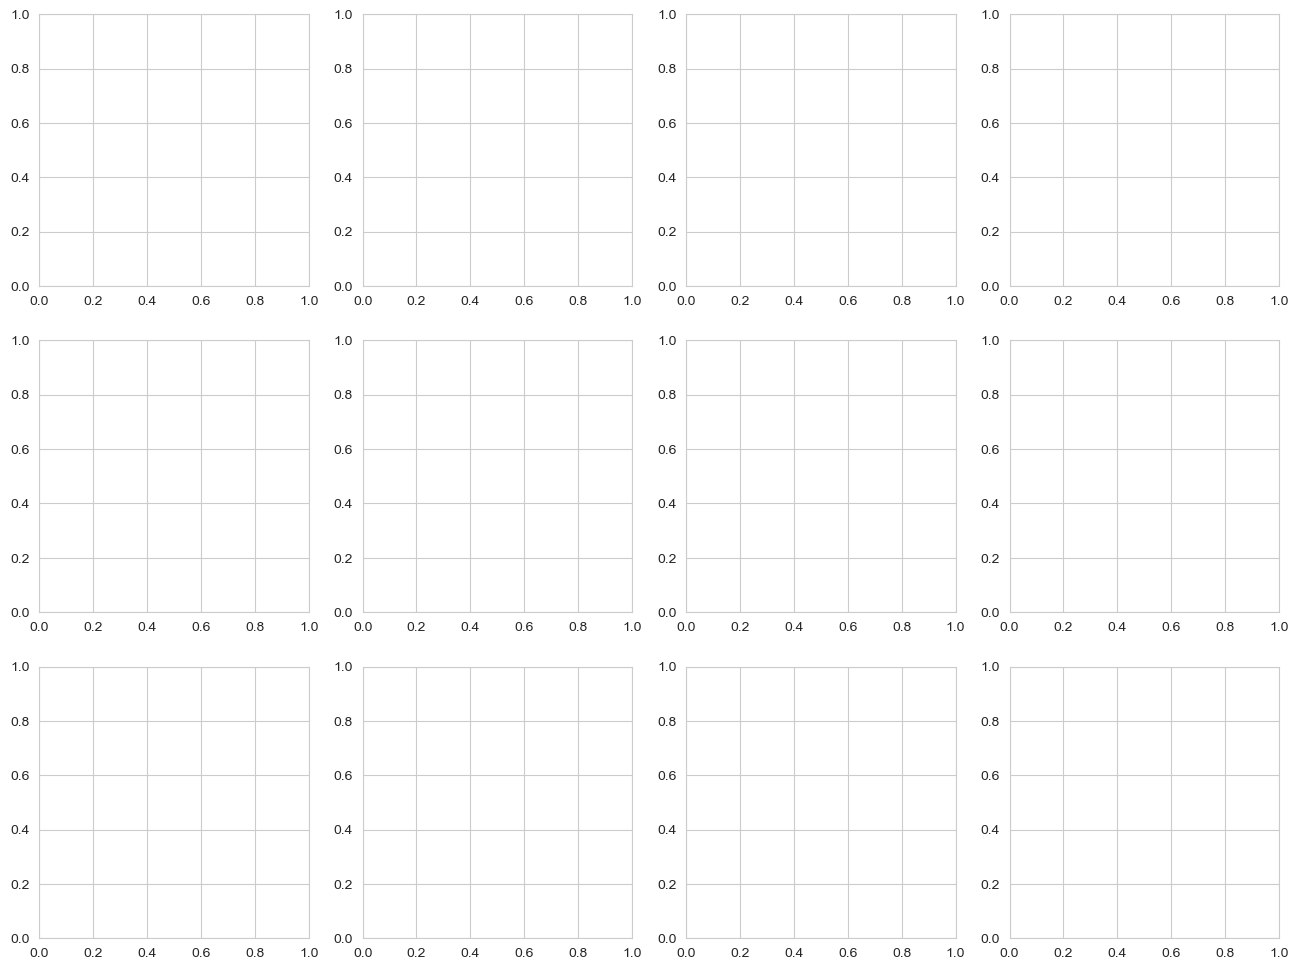

In [4]:
def generate_uvlif_spectrum_hard(aerosol_type, n_wavelengths=64, noise_level=0.15):
    """
    Generate synthetic UVLIF spectrum with more subtle differences between classes.
    This creates a more challenging classification problem.
    
    Parameters:
    -----------
    aerosol_type : str
        Type of aerosol ('biological', 'mineral_dust', 'organic_carbon', 'pah')
    n_wavelengths : int
        Number of spectral channels (wavelength bins)
    noise_level : float
        Amount of random noise to add (increased from easy version)
    """
    wavelengths = np.linspace(0, 1, n_wavelengths)
    
    # All classes now have overlapping spectral features
    # Main differences are in relative intensities and subtle peak positions
    
    if aerosol_type == 'biological':
        # Two peaks but at similar positions to organic carbon
        # Peak 1: slightly shifted from organic carbon
        peak1 = 2.5 * np.exp(-((wavelengths - 0.35)**2) / 0.015)
        # Peak 2: moderate intensity
        peak2 = 3.0 * np.exp(-((wavelengths - 0.52)**2) / 0.025)
        # Small broad background
        background = 0.8 * np.exp(-((wavelengths - 0.5)**2) / 0.3)
        spectrum = peak1 + peak2 + background
        
    elif aerosol_type == 'mineral_dust':
        # No longer very flat - has similar broad features to others
        # Broad peak similar position to biological but weaker
        peak1 = 1.2 * np.exp(-((wavelengths - 0.38)**2) / 0.02)
        peak2 = 1.8 * np.exp(-((wavelengths - 0.55)**2) / 0.03)
        # Stronger background than before
        background = 1.0 * np.exp(-((wavelengths - 0.5)**2) / 0.4)
        spectrum = peak1 + peak2 + background
        
    elif aerosol_type == 'organic_carbon':
        # Single peak but overlaps with biological peak positions
        # Peak position between biological peaks
        peak1 = 2.8 * np.exp(-((wavelengths - 0.42)**2) / 0.022)
        # Small secondary feature
        peak2 = 1.5 * np.exp(-((wavelengths - 0.58)**2) / 0.028)
        # Moderate background
        background = 0.7 * np.exp(-((wavelengths - 0.5)**2) / 0.35)
        spectrum = peak1 + peak2 + background
        
    elif aerosol_type == 'pah':
        # Shifted closer to organic carbon region
        # Main peak not as far in the red anymore
        peak1 = 1.8 * np.exp(-((wavelengths - 0.48)**2) / 0.02)
        peak2 = 3.2 * np.exp(-((wavelengths - 0.62)**2) / 0.025)
        # Similar background
        background = 0.6 * np.exp(-((wavelengths - 0.55)**2) / 0.35)
        spectrum = peak1 + peak2 + background
    
    # Add MORE noise (increased from 0.1 to 0.15 default)
    noise = noise_level * np.random.randn(n_wavelengths)
    spectrum = spectrum + noise
    
    # Add some random baseline drift to make it harder
    baseline_drift = 0.3 * np.random.randn() * np.linspace(0, 1, n_wavelengths)
    spectrum = spectrum + baseline_drift
    
    # Ensure non-negative
    spectrum = np.maximum(spectrum, 0)
    
    # Add random intensity scaling (simulating instrument variability)
    intensity_scale = np.random.uniform(0.85, 1.15)
    spectrum = spectrum * intensity_scale
    
    return spectrum


# Alternative version: VERY HARD - even more overlap
def generate_uvlif_spectrum_very_hard(aerosol_type, n_wavelengths=64, noise_level=0.2):
    """
    Generate synthetic UVLIF spectrum with maximum overlap between classes.
    This creates an extremely challenging classification problem where classes
    differ mainly in subtle peak ratios and minor peak shifts.
    
    Parameters:
    -----------
    aerosol_type : str
        Type of aerosol ('biological', 'mineral_dust', 'organic_carbon', 'pah')
    n_wavelengths : int
        Number of spectral channels (wavelength bins)
    noise_level : float
        Amount of random noise to add
    """
    wavelengths = np.linspace(0, 1, n_wavelengths)
    
    # All classes share very similar spectral features
    # Differences are only in subtle peak ratios and minor position shifts
    
    # Common background for all classes
    background = 1.2 * np.exp(-((wavelengths - 0.5)**2) / 0.4)
    
    if aerosol_type == 'biological':
        # Peak ratio: 1.0:1.3
        peak1 = 2.0 * np.exp(-((wavelengths - 0.42)**2) / 0.02)
        peak2 = 2.6 * np.exp(-((wavelengths - 0.54)**2) / 0.025)
        spectrum = background + peak1 + peak2
        
    elif aerosol_type == 'mineral_dust':
        # Peak ratio: 1.2:1.0 (reversed from biological)
        peak1 = 2.4 * np.exp(-((wavelengths - 0.43)**2) / 0.02)
        peak2 = 2.0 * np.exp(-((wavelengths - 0.55)**2) / 0.025)
        spectrum = background + peak1 + peak2
        
    elif aerosol_type == 'organic_carbon':
        # Peak ratio: 1.1:1.1 (nearly equal)
        peak1 = 2.2 * np.exp(-((wavelengths - 0.41)**2) / 0.02)
        peak2 = 2.2 * np.exp(-((wavelengths - 0.53)**2) / 0.025)
        spectrum = background + peak1 + peak2
        
    elif aerosol_type == 'pah':
        # Peak ratio: 0.9:1.4 (second peak stronger)
        peak1 = 1.8 * np.exp(-((wavelengths - 0.44)**2) / 0.02)
        peak2 = 2.8 * np.exp(-((wavelengths - 0.56)**2) / 0.025)
        spectrum = background + peak1 + peak2
    
    # High noise
    noise = noise_level * np.random.randn(n_wavelengths)
    spectrum = spectrum + noise
    
    # Significant baseline drift
    baseline_drift = 0.5 * np.random.randn() * np.linspace(-1, 1, n_wavelengths)
    spectrum = spectrum + baseline_drift
    
    # Variable intensity scaling
    intensity_scale = np.random.uniform(0.75, 1.25)
    spectrum = spectrum * intensity_scale
    
    # Random small peak position jitter (simulating calibration drift)
    if np.random.rand() > 0.5:
        shift = np.random.randint(-2, 3)
        spectrum = np.roll(spectrum, shift)
    
    # Ensure non-negative
    spectrum = np.maximum(spectrum, 0)
    
    return spectrum


# ============================================================================
# DEMONSTRATION CODE - Compare difficulty levels
# ============================================================================

if __name__ == "__main__":
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    sns.set_style('whitegrid')
    np.random.seed(42)
    
    aerosol_types = ['biological', 'mineral_dust', 'organic_carbon', 'pah']
    colors = ['blue', 'red', 'green', 'orange']
    
    # Create comparison figure
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    
    # Row 1: Easy (original)
    for idx, aerosol_type in enumerate(aerosol_types):
        for i in range(5):
            # Use original easy function
            spectrum = generate_uvlif_spectrum(aerosol_type)
            axes[0, idx].plot(spectrum, alpha=0.6, linewidth=1.5, color=colors[idx])
        axes[0, idx].set_title(f'{aerosol_type.replace("_", " ").title()}', 
                               fontsize=11, fontweight='bold')
        axes[0, idx].set_ylim([0, 8])
        if idx == 0:
            axes[0, idx].set_ylabel('EASY\n\nIntensity', fontsize=11, fontweight='bold')
    
    # Row 2: Hard
    for idx, aerosol_type in enumerate(aerosol_types):
        for i in range(5):
            spectrum = generate_uvlif_spectrum_hard(aerosol_type)
            axes[1, idx].plot(spectrum, alpha=0.6, linewidth=1.5, color=colors[idx])
        axes[1, idx].set_ylim([0, 8])
        if idx == 0:
            axes[1, idx].set_ylabel('HARD\n\nIntensity', fontsize=11, fontweight='bold')
    
    # Row 3: Very Hard
    for idx, aerosol_type in enumerate(aerosol_types):
        for i in range(5):
            spectrum = generate_uvlif_spectrum_very_hard(aerosol_type)
            axes[2, idx].plot(spectrum, alpha=0.6, linewidth=1.5, color=colors[idx])
        axes[2, idx].set_xlabel('Wavelength Channel', fontsize=10)
        axes[2, idx].set_ylim([0, 8])
        if idx == 0:
            axes[2, idx].set_ylabel('VERY HARD\n\nIntensity', fontsize=11, fontweight='bold')
    
    plt.suptitle('Comparison of Difficulty Levels for UVLIF Classification', 
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.savefig('difficulty_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("Difficulty Levels Created:")
    print("=" * 60)
    print("\n1. EASY (original function):")
    print("   - Well-separated spectral features")
    print("   - Distinct peak positions")
    print("   - Low noise")
    print("   - Expected accuracy: 97-99%")
    
    print("\n2. HARD (generate_uvlif_spectrum_hard):")
    print("   - Overlapping peak positions")
    print("   - Similar intensities between classes")
    print("   - Moderate noise + baseline drift")
    print("   - Intensity scaling variability")
    print("   - Expected accuracy: 85-92%")
    
    print("\n3. VERY HARD (generate_uvlif_spectrum_very_hard):")
    print("   - Minimal peak position differences")
    print("   - Differences mainly in peak ratios")
    print("   - High noise + significant baseline drift")
    print("   - Peak position jitter (calibration drift)")
    print("   - Large intensity variability")
    print("   - Expected accuracy: 70-85%")
    print("\n" + "=" * 60)

## Summary and Key Takeaways

### What We Learned:

1. **Data Splitting**
   - Training set: Learn patterns
   - Validation set: Tune hyperparameters
   - Test set: Final honest evaluation

2. **Model Evaluation**
   - Accuracy: Overall correct predictions
   - Confusion Matrix: Where errors occur
   - ROC/AUC: Trade-off between sensitivity and specificity
   - Precision/Recall: Class-specific performance

3. **Hyperparameter Tuning**
   - Grid search explores parameter combinations
   - Cross-validation prevents overfitting
   - Can significantly improve performance

4. **XGBoost Strengths**
   - Excellent for structured/tabular data
   - Handles complex patterns
   - Provides feature importance

### Next Steps:
In the next notebook, we'll use deep neural networks (DNNs) to tackle the same problem and compare approaches!

In [ ]:
# Save the best model for potential future use
import pickle

with open('best_xgboost_model.pkl', 'wb') as f:
    pickle.dump({
        'model': best_model,
        'scaler': scaler,
        'label_encoder': label_encoder
    }, f)

print("✓ Model saved to 'best_xgboost_model.pkl'")